# YOLO

In [21]:
from pathlib import Path

import ipywidgets

MODEL_DIR = Path("../model_repository")

model_dropdown = ipywidgets.Dropdown(
    options=[
        "yoloe-v8l-seg.pt",
        "yoloe-11l-seg.pt",
        "yoloe-11l-seg-pf.pt",
        "yoloe-v8l-seg-pf.pt",
    ],
    description="YOLOE",
)

model_dropdown

Dropdown(description='YOLOE', options=('yoloe-v8l-seg.pt', 'yoloe-11l-seg.pt', 'yoloe-11l-seg-pf.pt', 'yoloe-v…

## Load models

In [22]:
import numpy as np
from ultralytics.models.yolo import YOLOE
from ultralytics.models.yolo.yoloe import YOLOEVPDetectPredictor

model_name = MODEL_DIR / model_dropdown.value
yoloe = YOLOE(model_name).eval()
is_prompt_free = "-pf" in model_name.name

ref_paths = list(Path("ref").glob("*.jpg"))

## Few-shot image embeddings

In [23]:
from pathlib import Path

import cv2
import torch

predictor = YOLOEVPDetectPredictor(
    overrides={"task": "detect", "mode": "predict", "batch": 1}
)
predictor.setup_model(yoloe.model)

all_vpe = []

for ref_path in ref_paths:
    path = ref_path.with_name(f"{ref_path.stem}_obj.png")
    # ref_img = torchvision.io.read_image(ref_path)

    bg_path = ref_path.with_name(f"{ref_path.stem}_bg.png")
    bg_np = cv2.imread(str(bg_path), cv2.IMREAD_GRAYSCALE)
    assert bg_np is not None
    bg_np = (bg_np > (255 // 2)).astype(np.uint8)

    predictor.set_prompts(
        {
            "masks": [bg_np],  # (N, H, W)
            "cls": np.array([0]),  # [class1, class2, ...]
        }
    )

    vpe = predictor.get_vpe(ref_path)

    all_vpe.append(vpe)

Ultralytics 8.3.228 🚀 Python-3.12.11 torch-2.9.1 CPU (Apple M4 Pro)
YOLOe-v8l-seg summary (fused): 149 layers, 53,445,158 parameters, 2,254,374 gradients, 212.3 GFLOPs


## Text embedding

In [24]:
text_pe = yoloe.get_text_pe(["backpack"])

## Inference

In [27]:
all_vpe.append(text_pe)
avg_vpe = torch.mean(torch.stack(all_vpe), dim=0)
yoloe.set_classes(["obj"], avg_vpe)

results = yoloe.predict(sorted(Path().glob("frame*")), conf=0.0001, iou=0.01)


0: 384x640 9 objs, 147.4ms
1: 384x640 12 objs, 147.4ms
2: 384x640 8 objs, 147.4ms
3: 384x640 9 objs, 147.4ms
Speed: 1.0ms preprocess, 147.4ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


In [31]:
results[0].show(masks=True)

# Crop objects

In [29]:
import torch.nn.functional as F
from torchvision.ops import masks_to_boxes, roi_align

result = results[0]

img = torch.as_tensor(result.orig_img)
img = img.permute(2, 0, 1)
img = img.float() / 255.0
H_img, W_img = img.shape[-2:]

masks = torch.as_tensor(result.masks.data).float()
N, Hm, Wm = masks.shape

masks = F.interpolate(
    masks.unsqueeze(1),  # [N, 1, Hm, Wm]
    size=(H_img, W_img),
    mode="nearest",  # preserves binary mask
).squeeze(1)

# ---- 3. Bounding boxes from masks ----
boxes = masks_to_boxes(masks)  # [N, 4], (x1, y1, x2, y2)

# ---- 4. Create N masked images ----
# img: [3, H, W] -> [N, 3, H, W] (viewed via expand)
img_batch = img.unsqueeze(0).expand(N, -1, -1, -1)  # [N, 3, H, W]

# masks: [N, H, W] -> [N, 1, H, W]
masks_batched = masks.unsqueeze(1)  # [N, 1, H, W]

# Elementwise multiply to zero-out background
masked_imgs = img_batch * masks_batched  # [N, 3, H, W]

batch_idx = torch.arange(N).float().unsqueeze(1)  # [N, 1]
rois = torch.cat([batch_idx, boxes], dim=1)  # [N, 5] = [batch_idx, x1, y1, x2, y2]

crops = roi_align(
    masked_imgs,  # [N, 3, H_img, W_img]
    rois,  # [N, 5]
    output_size=(224, 224),
    spatial_scale=1.0,
    aligned=True,
)

0


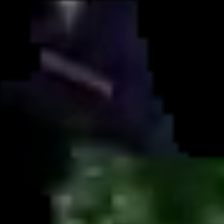

1


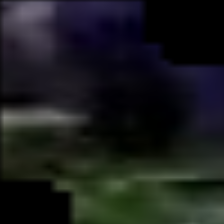

2


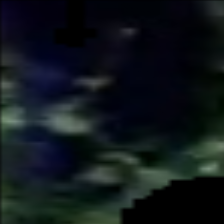

3


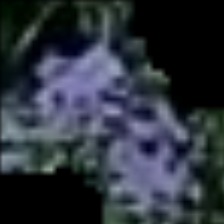

4


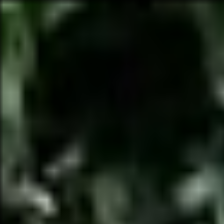

5


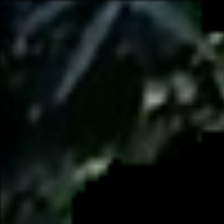

6


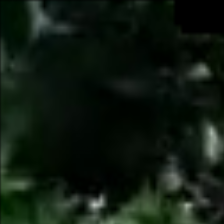

7


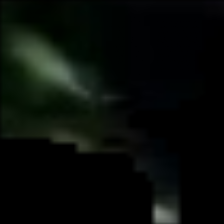

8


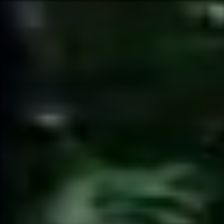

In [30]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image

for idx, crop in enumerate(crops):
    print(idx)
    rgb = crop[[2, 1, 0], ...]
    # Image()
    display(to_pil_image(rgb))

# DINOv3

In [32]:
import torch
from transformers import AutoImageProcessor, AutoModel

model = AutoModel.from_pretrained(
    "facebook/dinov3-vitl16-pretrain-sat493m",
    # "facebook/dinov3-convnext-large-pretrain-lvd1689m",
    # "facebook/dinov3-vitb16-pretrain-lvd1689m",
    device_map="auto",
    # "facebook/dinov3-vits16-pretrain-lvd1689m", device_map="auto"
    # "facebook/dinov3-convnext-tiny-pretrain-lvd1689m", device_map="auto"
)

In [33]:
from transformers.image_utils import load_image

dino_inputs = [load_image(to_pil_image(crop[[2, 1, 0], ...])) for crop in crops]
processor = AutoImageProcessor.from_pretrained(model.name_or_path)
dino_pixels = processor(
    images=dino_inputs,
    # do_rescale=False,
    # do_resize=False,
    return_tensors="pt",
    device=model.device,
)

ref_pixels = processor(
    images=[
        load_image(str(path.with_name(f"{path.stem}_obj.png"))) for path in ref_paths
    ],
    return_tensors="pt",
    device=model.device,
)

crops[0][0], dino_pixels.pixel_values[0][0]

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2229, 0.2283, 0.2336],
         [0.0000, 0.0000, 0.0000,  ..., 0.2209, 0.2270, 0.2331],
         [0.0000, 0.0000, 0.0000,  ..., 0.2176, 0.2246, 0.2315]]),
 tensor([[-2.0188, -2.0188, -2.0188,  ..., -2.0188, -2.0188, -2.0188],
         [-2.0188, -2.0188, -2.0188,  ..., -2.0188, -2.0188, -2.0188],
         [-2.0188, -2.0188, -2.0188,  ..., -2.0188, -2.0188, -2.0188],
         ...,
         [-2.0188, -2.0188, -2.0188,  ..., -0.9693, -0.9325, -0.9141],
         [-2.0188, -2.0188, -2.0188,  ..., -0.9693, -0.9509, -0.9141],
         [-2.0188, -2.0188, -2.0188,  ..., -0.9878, -0.9509, -0.9325]], device='mps:0'))

In [37]:
with torch.inference_mode():
    dino_input = model(**dino_pixels)
    ref_input = model(**ref_pixels)
    f6 = F.normalize(dino_input.pooler_output, dim=1)  # [6, 768]
    f3 = F.normalize(ref_input.pooler_output, dim=1)  # [3, 768]

    # Cosine similarity matrix: [3, 6]
    M = F.cosine_similarity(
        dino_input.pooler_output.unsqueeze(1),  # [6, 1, 768]
        ref_input.pooler_output.unsqueeze(0),  # [1, 3, 768]
        dim=-1,
    )  # 9, 3
    M = M.mean(dim=1)

    # sim_mean_of_similarities = M.mean(dim=1)

    # # For each of the 3 embeddings, find the index (0–5) with highest similarity
    best_indices = M.argmax()  # [3]

    print(best_indices)

tensor(3, device='mps:0')


In [ ]:
import numpy as np
import onnxruntime as ort

providers = [
    "CUDAExecutionProvider",
    (
        "CoreMLExecutionProvider",
        {
            "ModelFormat": "MLProgram",
            "RequireStaticInputShapes": "1",
            "AllowLowPrecisionAccumulationOnGPU": "1",
        },
    ),
    "CPUExecutionProvider",
]

ORT_TYPE_TO_NUMPY = {
    "tensor(float)": np.float32,
    "tensor(uint8)": np.uint8,
    "tensor(int8)": np.int8,
    "tensor(uint16)": np.uint16,
    "tensor(int16)": np.int16,
    "tensor(int32)": np.int32,
    "tensor(int64)": np.int64,
    "tensor(double)": np.float64,
    "tensor(bool)": bool,
    "tensor(float16)": np.float16,
}


def get_ort_session_device_type(session: ort.InferenceSession) -> str:
    # get_providers() returns e.g. ["CUDAExecutionProvider", "CPUExecutionProvider"]
    provider = session.get_providers()[0]
    # strip the common suffix and lower-case
    return provider[: provider.index("ExecutionProvider")].lower()

# BEN2

In [ ]:
import numpy as np
import onnxruntime as ort

session = ort.InferenceSession(MODEL_DIR / "ben2" / "fp16.onnx", providers=providers)
io_binding = session.io_binding()
input_node = session.get_inputs()[0]
output_node = session.get_outputs()[0]

In [ ]:
device_type = get_ort_session_device_type(session)
if device_type == "coreml":
    device_type = "cpu"

b, c, h, w = input_node.shape
input_batch = np.empty([b, c, h, w], dtype=np.float32)

if device_type != "cpu":
    input_ortvalue = ort.OrtValue.ortvalue_from_shape_and_type(
        input_node.shape, ORT_TYPE_TO_NUMPY[input_node.type], device_type
    )
    io_binding.bind_ortvalue_input(input_node.name, input_ortvalue)
else:
    io_binding.bind_cpu_input(input_node.name, input_batch)

output_ortvalue = ort.OrtValue.ortvalue_from_shape_and_type(
    output_node.shape, ORT_TYPE_TO_NUMPY[output_node.type], device_type
)
io_binding.bind_ortvalue_output(output_node.name, output_ortvalue)

In [ ]:
from itertools import batched

import cv2
from tqdm import tqdm

batch_size = 1
ref_paths = list(Path("ref").iterdir())

input_rgb_list: list[np.ndarray | None] = [None] * batch_size

for batch_paths in batched(tqdm(ref_paths), batch_size):
    for idx, img_path in enumerate(batch_paths):
        input_rgb_list[idx] = cv2.imread(str(img_path), cv2.IMREAD_COLOR_RGB)
        resized_image = cv2.resize(input_rgb_list[idx], (1024, 1024))
        chw_image = resized_image.transpose(2, 0, 1)
        np.divide(chw_image, np.iinfo(np.uint8).max, out=input_batch[idx])

    # Inference
    if device_type != "cpu":
        # Update existing OrtValue's memory in-place (no re-alloc)
        input_ortvalue.update_inplace(input_batch)
    session.run_with_iobinding(io_binding)
    outputs = output_ortvalue.numpy()

    # Postprocess
    for img_path, input_rgb, output in zip(batch_paths, input_rgb_list, outputs):
        raw_mask = output.squeeze()
        min_val = raw_mask.min()
        max_val = raw_mask.max()

        normalized_mask = (raw_mask - min_val) / (
            max_val - min_val + np.finfo(np.float32).eps
        )
        normalized_mask *= np.iinfo(np.uint8).max

        resized_mask = cv2.resize(
            normalized_mask.astype(np.uint8),
            dsize=(input_rgb.shape[1], input_rgb.shape[0]),
        )

        save_path = img_path.with_name(f"{img_path.stem}_bg.png")
        cv2.imwrite(str(save_path), resized_mask, [cv2.IMWRITE_PNG_COMPRESSION, 9])

        bgra_image = cv2.cvtColor(input_rgb, cv2.COLOR_RGB2BGRA)
        bgra_image[:, :, 3] = resized_mask
        save_path = img_path.with_name(f"{img_path.stem}_obj.png")
        cv2.imwrite(str(save_path), bgra_image, [cv2.IMWRITE_PNG_COMPRESSION, 9])

# Embedding

In [ ]:
from ultralytics.utils.downloads import GITHUB_ASSETS_STEMS

[i for i in GITHUB_ASSETS_STEMS if "yoloe" in i]